# API Facturas
API para la extraccion de facturas del sitio del SAT

## 0. Carga de librerias

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import base64
from PIL import Image #Libreria para el manejod e imagenes
import io
from selenium.webdriver.support.ui import Select
import selenium.webdriver.support.ui as ui
from selenium.webdriver.common.action_chains import ActionChains
import time
from tqdm import tqdm_notebook as tqdm
from os import listdir, remove
from os.path import isfile, join
import pathlib

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")
max_attempts=7

Populating the interactive namespace from numpy and matplotlib


## 1. Funciones

In [4]:
#lookuptag

#Descripción General: Funcion para buscar un texto específico en etiquetas similares
#Recibe: Lista de elementos (list_elements) que puede venir de un driver.find_elements...
#Recibe: Texto para comparar (selected_string) que debe ser igual al texto que se esta buscando
#Recibe: Despligue (verbose) para ver todos los elementos de la lista. False por default
#Regresa: Elemento seleccionado o en caso de no encontrar nada None

def lookuptag(list_elements,selected_string,verbose=False):
    if verbose == True:
        for i,e in enumerate(list_elements):
            print(i,":", e.text)
    else:
        pass
    
    for i,e in enumerate(list_elements):
        if e.text == selected_string:
            return e
        else:
            pass
    return None

#loadok

#Descripcion General: Funcion para asegurar la carga de una página despues de una secuencia
#Recibe: elemento de Selenium
#Recibe: tiempo en segundos de cada refrescado (refresh)
#Recibe: Maximo número de intentos para varificar que el elemento se cargo (max_tries)
#Recibe: Una etiqueta para identificar el elemento de prueba (stage) por default ""
#Recibe: Despliegue (verbose) para verificar el estado de la validación
#Regresa: None

def loadok(element, refresh=1, max_tries=3, stage="",verbose=False):
    loaded=False
    tries=0
    
    while 1:
        try:
            element
            loaded=True
            if verbose == True:
                return print(stage+"loaded [ok]")
            else:
                return None
        except:
            tries = tries + 1
            loaded=False
            time.sleep(refresh*tries)
            
            if tries >= max_tries:
                if verbose == True:
                    return print("Número de intentos superado. La página no ha cargado correctamente")
                else:
                    return None
def focus(driver):
    loaded=False
    wait=1
    while loaded==False:
        try:
            driver.switch_to_window(driver.window_handles[0])
            loaded=True
        except:
            time.sleep(wait)
            wait+=1
            if wait==max_attempts:
                print("Error en carga de pagina")
                
#--------------------------------------fechas_ini_fin-----------------------------------------------------------
def fechas_ini_fin():
    mes= 12 if time.localtime().tm_mon == 1 else time.localtime().tm_mon - 1
    mes_str = '0'+str(mes) if mes<10 else str(mes)

    anno = time.localtime().tm_year
    if mes in [1,3,5,7,8,10,12]:
        diafin=31
    elif mes in [4,6,9,11]:
        diafin=30
    else:
        if anno%4==0:
            diafin=29
        else:
            diafin=28
    fecha_ini="'01/"+mes_str+"/"+str(int(anno))+"'"
    fecha_fin="'"+str(diafin)+"/"+mes_str+"/"+str(int(anno))+"'"
    return [fecha_ini,fecha_fin,anno,mes,diafin]
                


## 2. Input

In [3]:
#Enviar Captcha y solicitar rfc, pwd y cap
#str_rfc=input("Ingresa tu RFC:")
#str_pwd=input("Ingresa tu contraseña:")
str_rfc='IADA810218HG5'
str_pwd='DaSa0520'

## 3. Login en  página del SAT

Recibe Datos de Usuario y Captcha

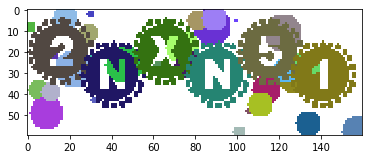

Ingresa el Captcha:2NXN51



Ejecucion correcta


In [762]:
load =False
while load==False:
    try:
        #Deteccion de la raiz de los archivos
        directorio=pathlib.Path().absolute()
        filespath=str(directorio)+'/temp'

        #Seleccion de carpeta temporal para descarga de archivow
        chrome_options = webdriver.ChromeOptions()
        prefs = {'download.default_directory' : filespath}
        chrome_options.add_experimental_option('prefs', prefs)
        options = webdriver.ChromeOptions() 
        options.add_argument("download.default_directory="+filespath)

        #Inicializacion de driver de Selenium
        driver = webdriver.Chrome(chrome_options=chrome_options)

        #Inicializar Navegador y entrar a pagina web
        driver.get("https://portalcfdi.facturaelectronica.sat.gob.mx/")
        
        time.sleep(2)

        #Espera dináminca de la carga del captcha
        loadok(driver.find_elements_by_tag_name("img"))

        #Obtener Captcha
        images=driver.find_elements_by_tag_name("img")
        captcha = images[1].get_attribute('src')[23:]

        #Integrar Captcha
        image_decoded = base64.b64decode(str(captcha))       
        image = Image.open(io.BytesIO(image_decoded))

        #Mostrar captcha en jupiter notebook
        imgplot = plt.imshow(image)
        plt.show()

        #Guardar Captcha

        #fileName = 'captcha.jpeg'
        #imagePath = ("captcha.jpeg")
        #image.save(imagePath, 'jpeg')

        str_cap=input("Ingresa el Captcha:")
        
        load=True
    except:
        driver.close()
        load=False

#----------------------## 3. Robot de navegacion y descarga de facturas ##-------------------------------#

#---------------------------------------Ingreso de credenciales------------------------------------------
loaded=False
wait=1
while loaded==False:
    try:
        rfc = driver.find_element_by_id("rfc")
        rfc.clear()
        rfc.send_keys(str_rfc)

        pwd=driver.find_element_by_id("password")
        pwd.clear()
        pwd.send_keys(str_pwd)

        cap=driver.find_element_by_id("userCaptcha")
        cap.clear()
        cap.send_keys(str_cap)

        btn_Login=driver.find_element_by_id("submit")
        btn_Login.click()
        loaded=True
    except:
        loaded=False
        time.sleep(wait)
        wait=wait+1
        #focus(driver)
        print('Waiting in Login... ',wait)
        if wait==max_attempts:
            break
                
#--------------------------Ingreso a consulta de Facturas Recibidas---------------------------------------
loaded=False
wait=1
while loaded==False:
    try:
        #Click en Consultar Facturas Recibidas
        #loadok(driver.find_element_by_link_text("Consultar Facturas Recibidas"))
        lnk_Emitidas= driver.find_element_by_link_text("Consultar Facturas Recibidas")
        lnk_Emitidas.click()
        loaded=True
    except:
        loaded=False
        time.sleep(wait)
        wait=wait+1
        #focus(driver)
        print('Waiting in Ingreso a Consulta Facturas Recibidas... ',wait)
        if wait==max_attempts:
            break
#--------------------------Parametros de Consulta de Facturas Recibidas---------------------------------------            
loaded=False
wait=1
while loaded==False:
    try:
        #Selección del tipo de busqueda de facturas "Por fecha"
        #loadok(driver.find_element_by_id("ctl00_MainContent_RdoFechas"))
        sel_fecha_emision=driver.find_element_by_id("ctl00_MainContent_RdoFechas")
        sel_fecha_emision.click()
        time.sleep(1)

        #Selección del mes
        mes= 12 if time.localtime().tm_mon == 1 else time.localtime().tm_mon - 1

        #loadok(Select(driver.find_element_by_id('ctl00_MainContent_CldFecha_DdlMes')))
        sel_mes = Select(driver.find_element_by_id('ctl00_MainContent_CldFecha_DdlMes'))
        sel_mes.select_by_value(str(mes))

        #Click en el boton de búsqueda de las facturas del mes
        #loadok(driver.find_element_by_name("ctl00$MainContent$BtnBusqueda"))
        btn_BuscarCFDI=driver.find_element_by_name("ctl00$MainContent$BtnBusqueda")
        btn_BuscarCFDI.click()

        #Seleccion del Año
        #anno= time.localtime().tm_year - 1 if time.localtime().tm_mon == 1 else time.localtime().tm_year
        ## Scraping pendiente de la seleccion del año ------------------ !!!!
        
        loaded=True
        
    except:
        x=input()
        loaded=False
        time.sleep(wait)
        wait=wait+1
        #focus(driver)
        print('Waiting in Parametros de Consulta Facturas Recibidas... ',wait)
        if wait==max_attempts:
            break


#------------------------------Descarga de todas las facturas en las páginas disponibles----------------------
time.sleep(2)
fallos=[]
btns_Descarga=[]
btns_Descarga = driver.find_elements_by_id("BtnDescarga")

for j in tqdm(range(len(btns_Descarga)),'Facturas'):
    try:
        driver.execute_script(btns_Descarga[j].get_attribute('onclick')) #Ejecuta el metodo de Java Script para la descarga
        #Verificacion de descarga --- OPTIMIZACION PENDIENTE TIP: Comparar nombre de archivo con el desplegado en la pagina
        time.sleep(3)
        #loadok(driver.switch_to_window(driver.window_handles[1]),stage=str(j),verbose=False) #Mueve el foco a la ventana de descarga
        driver.switch_to_window(driver.window_handles[1]) #Mueve el foco a la ventana de descarga
        driver.close()  #Cierra pagina de descarga
        driver.switch_to_window(driver.window_handles[0])    
    except:
        fallos.append(j) 
#-------------------------------------Regreso a Inicio------------------------------------
loaded=False
wait=1
while loaded==False:
    try:
        #loadok(driver.find_elements_by_tag_name('a'))
        driver.execute_script("window.scrollTo(0, 0);")
        btn_Inicio=lookuptag(driver.find_elements_by_tag_name('a'), 'Inicio')
        btn_Inicio.click()
        loaded=True
    except:
        loaded=False
        time.sleep(wait)
        wait=wait+1
        #focus(driver)
        print('Waiting in Regreso a Inicio... ',wait)
        if wait==max_attempts:
            break
#---------------------Cambio a Facturas Emitidas------------------------------------   
loaded=False
wait=1
while loaded==False:
    try:
        #Click en Consultar Facturas Recibidas
        #loadok(driver.find_element_by_link_text("Consultar Facturas Emitidas"))
        lnk_Emitidas= driver.find_element_by_link_text("Consultar Facturas Emitidas")
        lnk_Emitidas.click()
        
        loaded=True
    except:
        loaded=False
        time.sleep(wait)
        wait=wait+1
        focus(driver)
        print('Waiting in Cambio a Facturas Emitidas... ',wait)
        if wait==max_attempts:
            break
#---------------------Ingreso de Parametros de de Facturas Emitidas------------------------------------               
loaded=False
wait=1
while loaded==False:
    try:
        #Selección del tipo de busqueda de facturas "Por fecha"
        #loadok(driver.find_element_by_id("ctl00_MainContent_RdoFechas"))
        sel_fecha_emision=driver.find_element_by_id("ctl00_MainContent_RdoFechas")
        sel_fecha_emision.click()
        #Selección de fechas inicial y final
        f=fechas_ini_fin()
        fecha_inicial=f[0]
        driver.execute_script("updateDateField('ctl00$MainContent$CldFechaInicial2$Calendario_text',"+fecha_inicial+");")
        fecha_final=f[1]
        driver.execute_script("updateDateField('ctl00$MainContent$CldFechaFinal2$Calendario_text',"+fecha_final+");")
        #Click en el boton de búsqueda de las facturas del mes
        #loadok(driver.find_element_by_name("ctl00$MainContent$BtnBusqueda"))
        btn_BuscarCFDI=driver.find_element_by_name("ctl00$MainContent$BtnBusqueda")
        btn_BuscarCFDI.click()
        
        loaded=True
    except:
        loaded=False
        time.sleep(wait)
        wait=wait+1
        focus(driver)
        print('Waiting in Ingreso de parametros de Facturas Emitidas... ',wait)
        if wait==max_attempts:
            break

#-----------------------------------------Descarga de facturas emitidas----------------------------------------
time.sleep(2)
fallos=[]
btns_Descarga=[]
btns_Descarga = driver.find_elements_by_id("BtnDescarga")

for j in tqdm(range(len(btns_Descarga)),'Facturas'):
    try:
        driver.execute_script(btns_Descarga[j].get_attribute('onclick')) #Ejecuta el metodo de Java Script para la descarga
        #Verificacion de descarga --- OPTIMIZACION PENDIENTE TIP: Comparar nombre de archivo con el desplegado en la pagina
        time.sleep(3)
        #loadok(driver.switch_to_window(driver.window_handles[1]),stage=str(j),verbose=False) #Mueve el foco a la ventana de descarga
        driver.switch_to_window(driver.window_handles[1]) #Mueve el foco a la ventana de descarga
        driver.close()  #Cierra pagina de descarga
        driver.switch_to_window(driver.window_handles[0])    
    except:
        fallos.append(j)
        
#-----------------------------------Fin del API de descarga de facturas---------------------------------------
driver.close()